## LDA MODEL with GenSim and Spacy. Nishrin Kachwala 11/27/2020

In [ ]:
!python -q -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=2dc0cbff031b7bf736583c9b943e578a7eddcfb9e6a0ea4b6a35e11135995ff8
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3v3lsm0/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#import en_vectors_web_lg 
import en_core_web_lg
from tqdm import tqdm_notebook as tqdm
from pprint import pprint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/OMDENA_WRI_CLIMATE/combined_lightscrape.csv')  #11/26/2020/ includes only first set of light scraped data
df.head()

,Unnamed: 0,Unnamed: 0.1,website_link,title,description,description_detection
0,0,0,https://www.12tree.de/portfolio,Portfolio — 12Tree Finance,"Since 2017, we have made investments in TWELVE...",en
1,1,1,https://www.12tree.de/portfolio,Portfolio — 12Tree Finance,"Native hardwoods, teak, acacia, cocoa, coffee,...",en
2,2,2,https://www.12tree.de/portfolio,Portfolio — 12Tree Finance,The latest technology and best agricultural pr...,en
3,3,3,https://www.12tree.de/portfolio,Portfolio — 12Tree Finance,Located in the northeast of the Dominican Repu...,en
4,4,4,https://www.12tree.de/portfolio,Portfolio — 12Tree Finance,"This 30-year-old coconut farm set across 2,132...",en


In [ ]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66054 entries, 0 to 66053
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             66054 non-null  int64 
 1   Unnamed: 0.1           66054 non-null  int64 
 2   website_link           66054 non-null  object
 3   title                  66054 non-null  object
 4   description            66054 non-null  object
 5   description_detection  66054 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.0+ MB


In [ ]:
import regex as re

df['clean'] = df['description'].str.lower()

df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^\w\d\s\']+', '', x))

# removing numbers and $ signs from the column
df['clean'] = df.loc[:,('clean')].str.replace(r'[0-9]', '')  

df.sample(5, random_state = 5)

,Unnamed: 0,Unnamed: 0.1,website_link,title,description,description_detection,clean
8073,8073,8073,https://www.bioversityinternational.org/news/d...,Break down barriers between seed banks and fie...,But if we stop looking at these two forms of c...,en,but if we stop looking at these two forms of c...
60272,18133,18133,https://scc.ca.gov/2017/06/21/sfv/,State Coastal Conservancy Grants $4 million to...,The San Fernando Valley Stormwater Capture Pro...,en,the san fernando valley stormwater capture pro...
4276,4276,4276,https://www.bioversityinternational.org/news/d...,Sustainable food systems include food from for...,"Globally, it is estimated that billions of peo...",en,globally it is estimated that billions of peop...
52251,10112,10112,https://wle.cgiar.org/thrive/big-questions/why...,Not all dams are equal (but some are more equa...,The Volta exemplifies a number of these tradeo...,en,the volta exemplifies a number of these tradeo...
8025,8025,8025,https://www.bioversityinternational.org/news/d...,Why a gender approach is important for conserv...,"Every year on October 15th, the UN celebrates ...",en,every year on october th the un celebrates int...


In [ ]:
nlp= spacy.load("en")


Using the Counter method to fidn the count of most commonly occuring words. This will be added to the stopwords

In [ ]:
from collections import Counter
counter_comm_words = Counter(" ".join(df["clean"]).split()).most_common(100)
counter_comm_words
comm = pd.DataFrame(counter_comm_words, columns = ['Word','Count'])   #Using Counter method


In [ ]:
stop_list = comm['Word'].to_list()  #creating new additions for stopwords

In [ ]:
#  list of stop words.

# Updates spaCy's default stop words list with  additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


Lemmatize and Remove stopwords

In [ ]:
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends these functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

In [ ]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(newest_doc):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [ ]:
len(corpus)

66054

In [ ]:
#Save the Dict and Corpus

words.save('/content/drive/My Drive/Colab Notebooks/OMDENA_WRI_CLIMATE/words.dict')  # save dict to disk

corpora.MmCorpus.serialize('bow_corpus.mm', corpus)  # save corpus to disk

In [ ]:
##Load them back
#loaded_dict = corpora.Dictionary.load('words.dict')

In [ ]:
#corpus = corpora.MmCorpus('/content/drive/My Drive/Colab Notebooks/OMDENA_WRI_CLIMATE/bow_corpus.mm')
#for line in corpus:
 #   print(line)

#LDA MODEL
**Parameters in the model:**
*   *passes* controls how often we train the model on the entire corpus (set to 10)
chunksize controls how many documents are processed at a time in the training algorithm.
*   *chunksize* controls how many documents are processed at a time in the training algorithm.
*   *Dirichlet hyperparameter alpha* is the Document-Topic Density
*   *Dirichlet hyperparameter beta* is Word-Topic Density
*   *Perplexity* is a statistical measure of how well a probability model predicts a sample the statistic makes more sense when comparing it across different models with varying the number of topics. The model with the lowest perplexity is generally considered the “best”








In [ ]:
#LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=20, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           iterations=500,
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics(num_topics=20))

[(0,
  '0.054*"solution" + 0.033*"california" + 0.033*"authorization" + '
  '0.031*"member" + 0.028*"process" + 0.028*"problem" + 0.021*"individual" + '
  '0.019*"advance" + 0.019*"expert" + 0.018*"team"'),
 (1,
  '0.067*"covid" + 0.048*"pandemic" + 0.034*"crisis" + 0.019*"look" + '
  '0.018*"today" + 0.015*"gap" + 0.015*"urban" + 0.014*"response" + '
  '0.013*"big" + 0.011*"follow"'),
 (2,
  '0.066*"economic" + 0.041*"social" + 0.033*"impact" + 0.027*"financial" + '
  '0.024*"lead" + 0.022*"investment" + 0.021*"group" + 0.020*"model" + '
  '0.018*"potential" + 0.017*"coastal"'),
 (3,
  '0.094*"business" + 0.043*"service" + 0.034*"possible" + 0.029*"find" + '
  '0.026*"large" + 0.024*"ecosystem" + 0.024*"high" + 0.023*"result" + '
  '0.020*"rise" + 0.019*"demand"'),
 (4,
  '0.071*"opportunity" + 0.060*"risk" + 0.033*"vaccine" + 0.023*"strong" + '
  '0.020*"science" + 0.019*"connect" + 0.017*"clean" + 0.017*"disease" + '
  '0.016*"workplace" + 0.014*"sea"'),
 (5,
  '0.076*"city" + 0.069

In [ ]:
pprint(lda_model.top_topics(corpus=corpus, topn=20))


[([(0.02367462, 'year'),
   (0.020194247, 'future'),
   (0.019897925, 'country'),
   (0.019813951, 'system'),
   (0.018356813, 'include'),
   (0.017019168, 'health'),
   (0.01696203, 'create'),
   (0.016201764, 'way'),
   (0.01565572, 'report'),
   (0.015325624, 'challenge'),
   (0.014486713, 'organization'),
   (0.013324664, 'great'),
   (0.013134854, 'innovation'),
   (0.012482208, 'build'),
   (0.0123816235, 'million'),
   (0.012226305, 'action'),
   (0.011060462, 'key'),
   (0.010135024, 'area'),
   (0.009743776, 'share'),
   (0.009367899, 'approach')],
  -2.899663358306975),
 ([(0.040157314, 'industry'),
   (0.039293047, 'develop'),
   (0.03437303, 'increase'),
   (0.029435644, 'policy'),
   (0.026911316, 'access'),
   (0.02575895, 'improve'),
   (0.0227851, 'like'),
   (0.0226371, 'address'),
   (0.020608373, 'reduce'),
   (0.01740926, 'right'),
   (0.01720753, 'enable'),
   (0.016497452, 'emission'),
   (0.015870964, 'collaboration'),
   (0.01515578, 'meeting'),
   (0.0142819, '

Model perplexity and topic coherence Scores: These scores are a measure to judge how good a given topic model is. 
*   *Topic Coherence* measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.
*   *Perplexity* is a statistical measure of how well a probability model predicts a sample the statistic makes more sense when comparing it across different models with varying the number of topics. The model with the lowest perplexity is generally considered the “best”


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_list, dictionary=words, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.14498614884733

Coherence Score:  0.3250996371050411


LOOP OVER NUMBER OF TOPICS TO FIND BEST MODEL

In [ ]:
def compute_coherence_values(corpus, id2word, texts, limit, start=4, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word) 
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=2,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        model_list.append(model_lda)
        coherence_values.append(model_lda.get_coherence())

    return model_list, coherence_values

Best model chosen with 16 topics

In [ ]:
# Can take a long time to run. Best Mnumber of topics =16 
model_list, coherence_values = compute_coherence_values(corpus=corpus, id2word=words, texts=doc_list, start=4, limit=25, step=4)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

ValueError: ignored

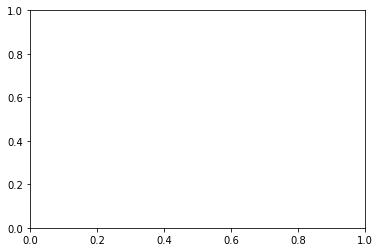

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#VISUALIZE RESULTS

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.3460,"research, bioversity, program, datum, organization, social, learn, partner, measure, share","[progress, nua, pilot, london, demonstrate, profitability, replicability, nutrient, upcycle, pil..."
1,1,7.0,0.5171,"research, bioversity, program, datum, organization, social, learn, partner, measure, share","[th, hulu, documentary, greta, release, special, screening, cinema, previously, unseen, footage,..."
2,2,6.0,0.3139,"local, service, develop, impact, protect, seed, ecosystem, market, approach, process","[new, article, present, vulnerability, mapping, model, turn, online, tool, contribute, scienceba..."
3,3,5.0,0.5621,", sustainable, biodiversity, climate, genetic, agricultural, new, national, agriculture, specie","[shoulder, shoulder, environment, natural, , ha, land, regenerate, dry, marchapril, good, care..."
4,4,6.0,0.4667,"local, service, develop, impact, protect, seed, ecosystem, market, approach, process","[mentor, goal, strengthen, civil, society, ability, address, social, injustice, large, nascent, ..."
5,5,0.0,0.4096,"education, unesco, training, meeting, public, regional, centre, discuss, ministry, agenda","[unesco, organize, session, wsis, forum, , wednesday, morning, unesco, bring, high, level, pan..."
6,6,6.0,0.3220,"local, service, develop, impact, protect, seed, ecosystem, market, approach, process","[meeting, mercy, awino, okoth, mother, yearold, blevin, busy, appointment, try, college, continu..."
7,7,5.0,0.4030,", sustainable, biodiversity, climate, genetic, agricultural, new, national, agriculture, specie","[covid, guidance, note, genderbased, violence, service, provision, , syria, , , enar]"
8,8,5.0,0.5513,", sustainable, biodiversity, climate, genetic, agricultural, new, national, agriculture, specie","[treaty, genetic, agriculture, implement, multilateral, , learn, module, , explain, multilat..."
9,9,4.0,0.5105,"report, analysis, order, chain, sustainability, poverty, critical, review, ecological, smallholder","[build, extensive, desk, review, informant, interview, diverse, sector, stakeholder, report, con..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5008,"education, unesco, training, meeting, public, regional, centre, discuss, ministry, agenda","[speak, sonia, alvarez, head, teacher, juan, luis, vives, valparaiso, chile, education, prison, ..."
1,1.0,0.5176,"woman, economic, like, vegetable, loss, man, love, indigenous, represent, silc","[saving, lending, money, modest, james, malueth, survive, reduce, rubble, , james, like, fell..."
2,2.0,0.5553,"crs, high, come, farm, reduce, nature, find, available, household, way","[found, , crs, rice, bowl, annually, ask, faithful, catholics, sacrifice, brother, overseas, m..."
3,3.0,0.5797,"ensure, good, study, activity, member, strategy, build, promote, effort, practice","[dr, sebastien, carpentier, bioscience, engineer, specialize, cell, gene, biotechnology, agricul..."
4,4.0,0.5198,"report, analysis, order, chain, sustainability, poverty, critical, review, ecological, smallholder","[threat, napomarañon, basin, network, road, oil, palm, plantation, log, operation, typically, fo..."
5,5.0,0.7253,", sustainable, biodiversity, climate, genetic, agricultural, new, national, agriculture, specie","[ , expand, dairy, initiative, new, location, bangladesh, inaugurate, dairy, component, sustain..."
6,6.0,0.6768,"local, service, develop, impact, protect, seed, ecosystem, market, approach, process","[west, africa, place, world, marine, coastal, dire, establish, manage, collaboration, local, mar..."
7,7.0,0.6339,"research, bioversity, program, datum, organization, social, learn, partner, measure, share","[finish, bachelor, biology, gain, experience, realize, want, learn, natural, social, mechanism, ..."
8,8.0,0.5485,"fund, condition, end, small, association, staff, adapt, island, native, especially","[ibutton, small, steelencased, computer, chip, record, temperature, humidity, economical, userfr..."
9,9.0,0.5385,"world, day, role, income, event, cultural, case, hold, disease, africa","[unesco, receive, damage, cause, great, dam, marib, airstrike, night, , accord, report, receiv..."


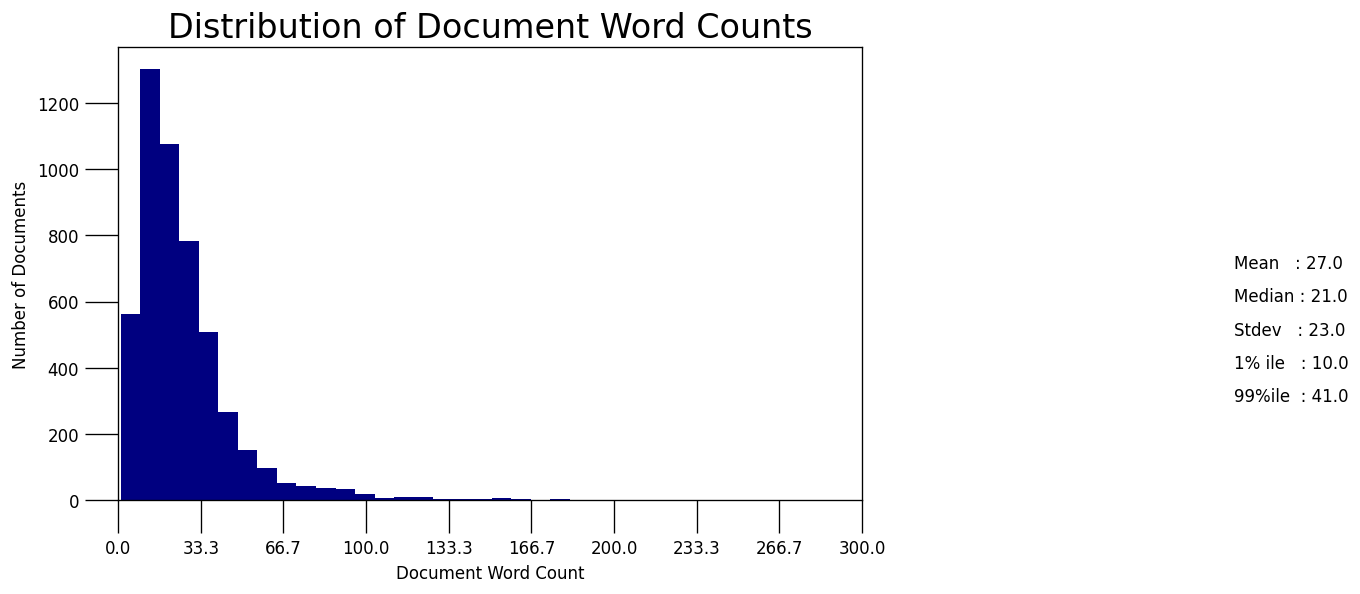

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,5), dpi=120)
plt.hist(doc_lens, bins = 50, color='navy')
plt.text(450, 700, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(450,  600, "Median : " + str(round(np.median(doc_lens))))
plt.text(450,  500, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(450,  400, "1% ile   : " + str(round(np.quantile(doc_lens, q=0.15))))
plt.text(450,  300, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.85))))

plt.gca().set(xlim=(0, 300), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=20)
plt.xticks(np.linspace(0,300,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

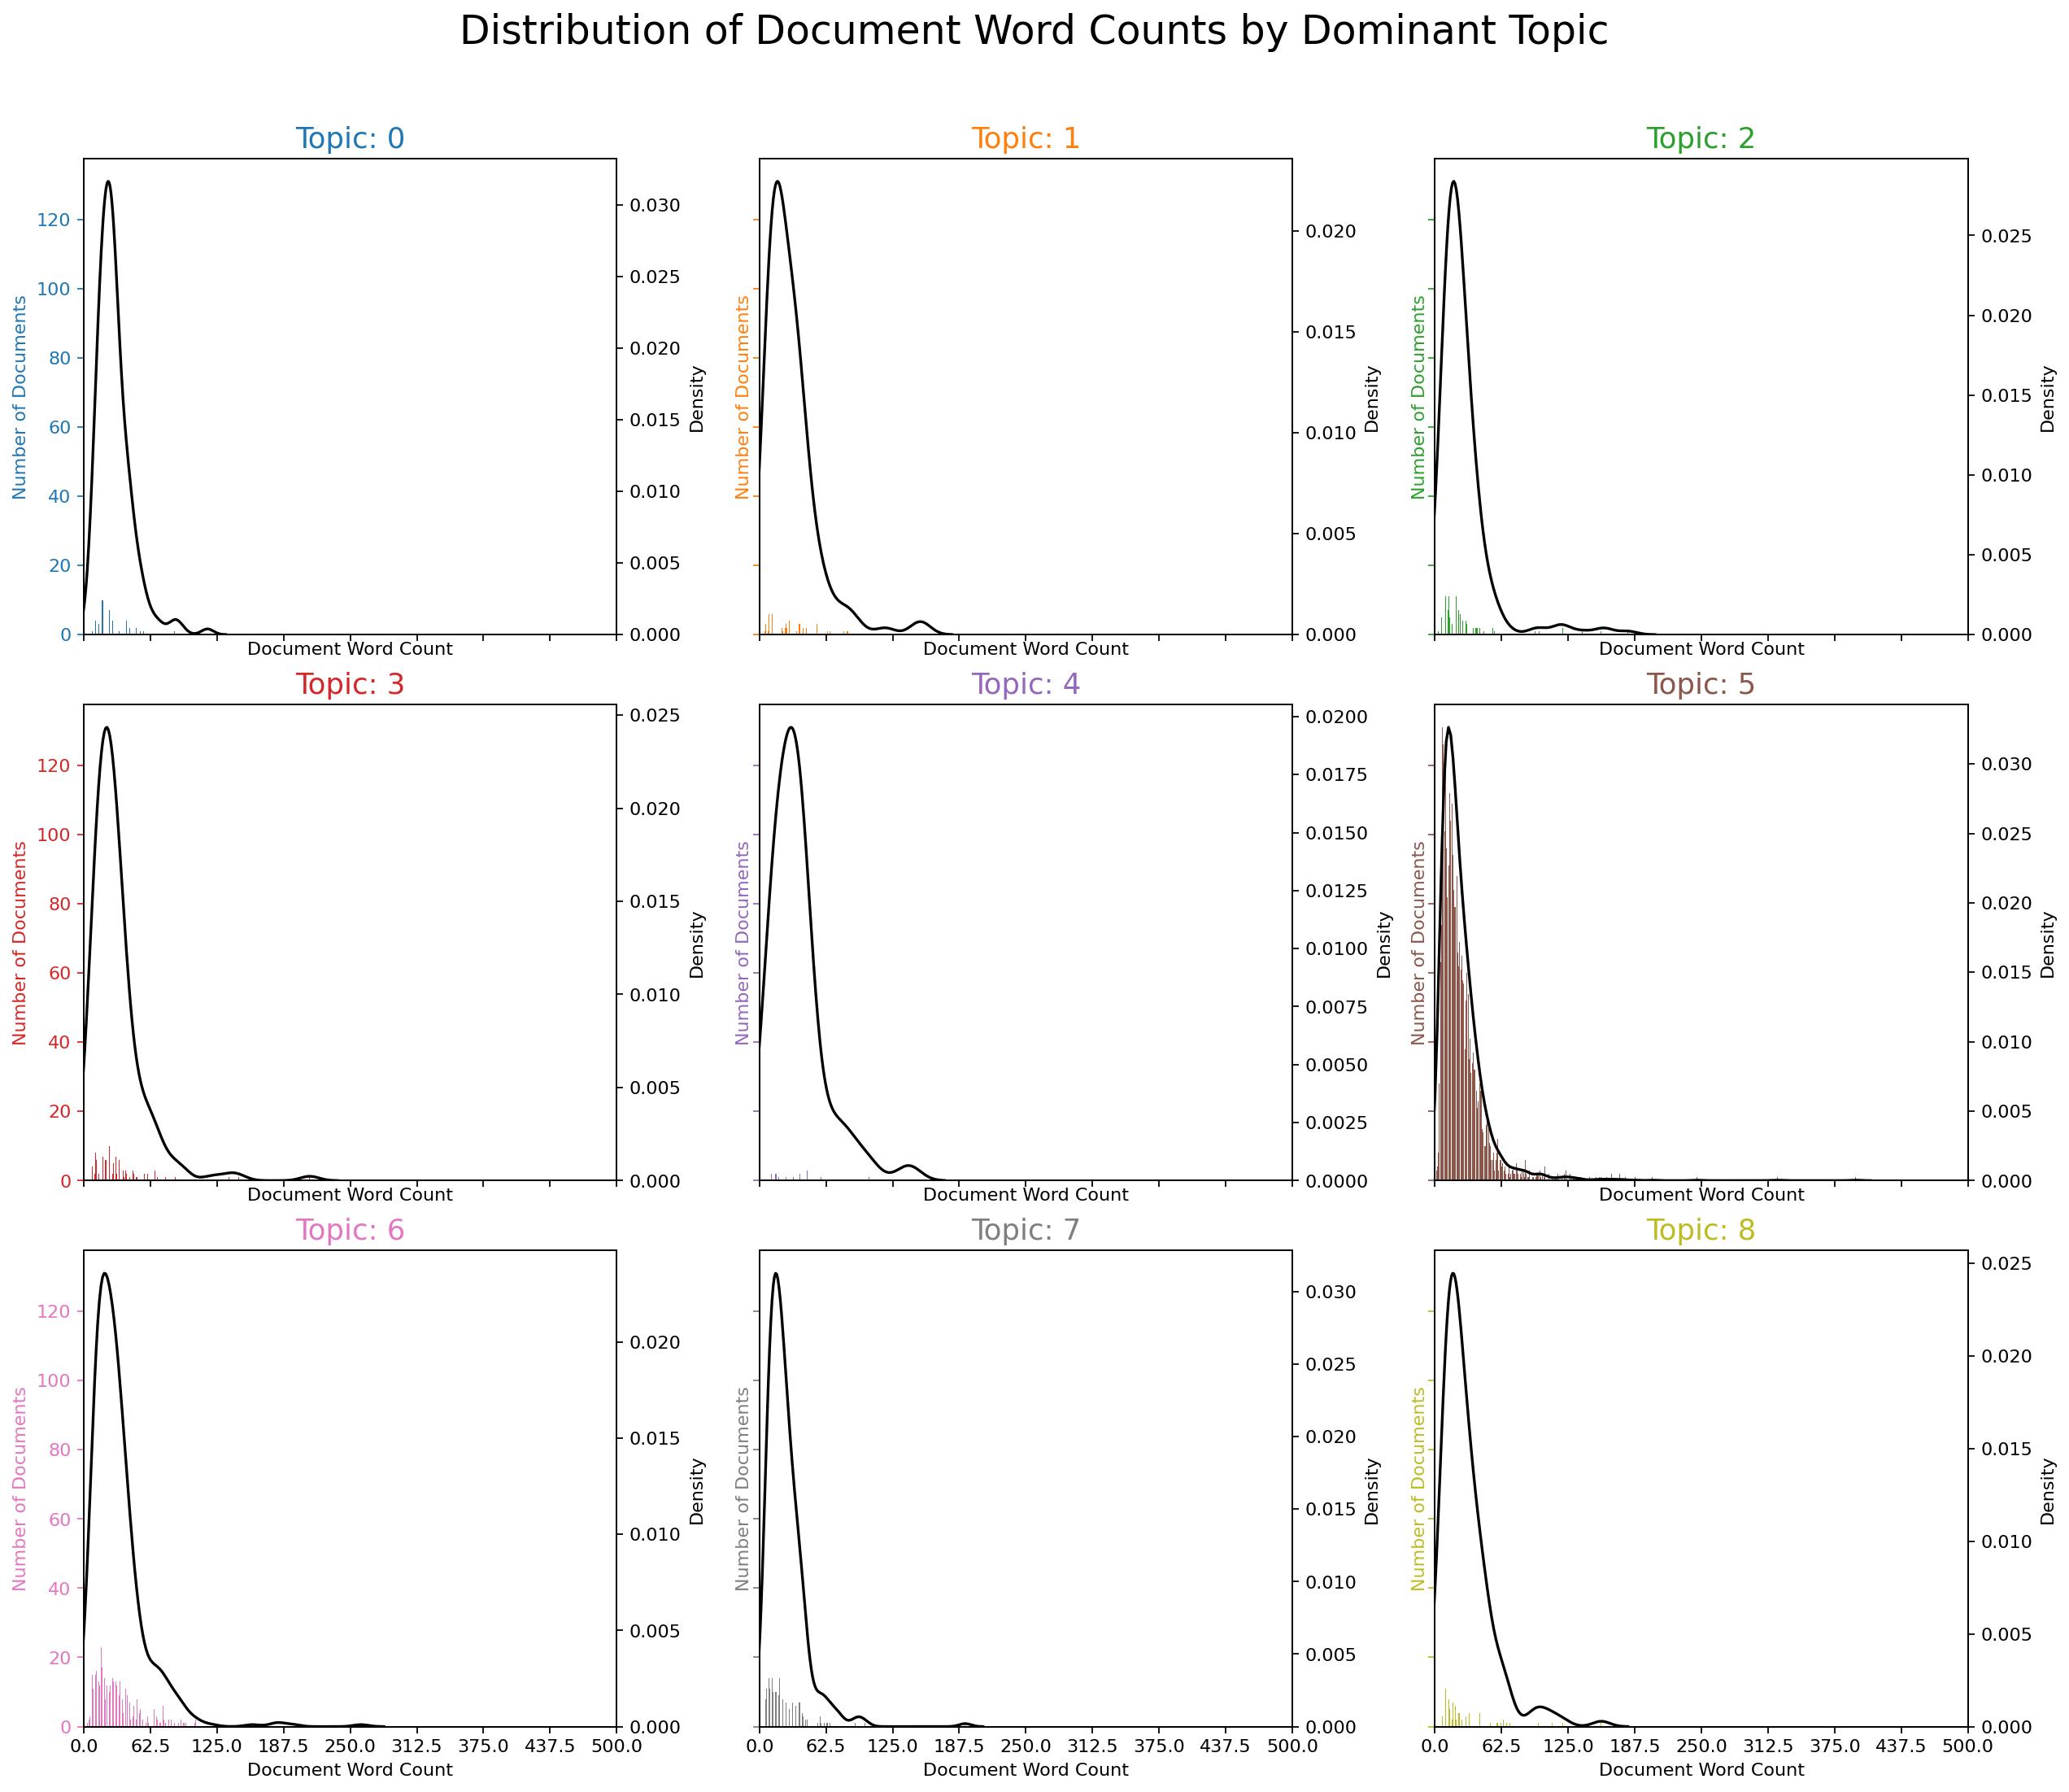

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,3,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 500, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 500), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,500,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

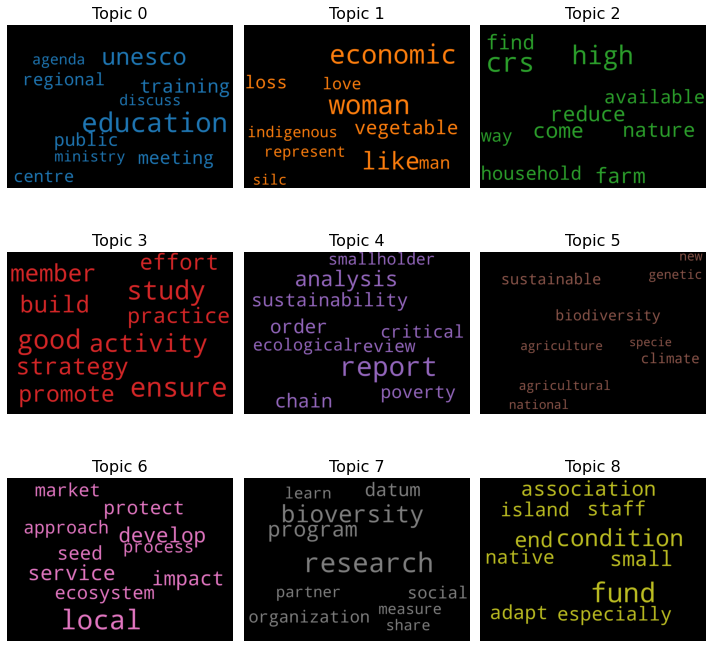

In [ ]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

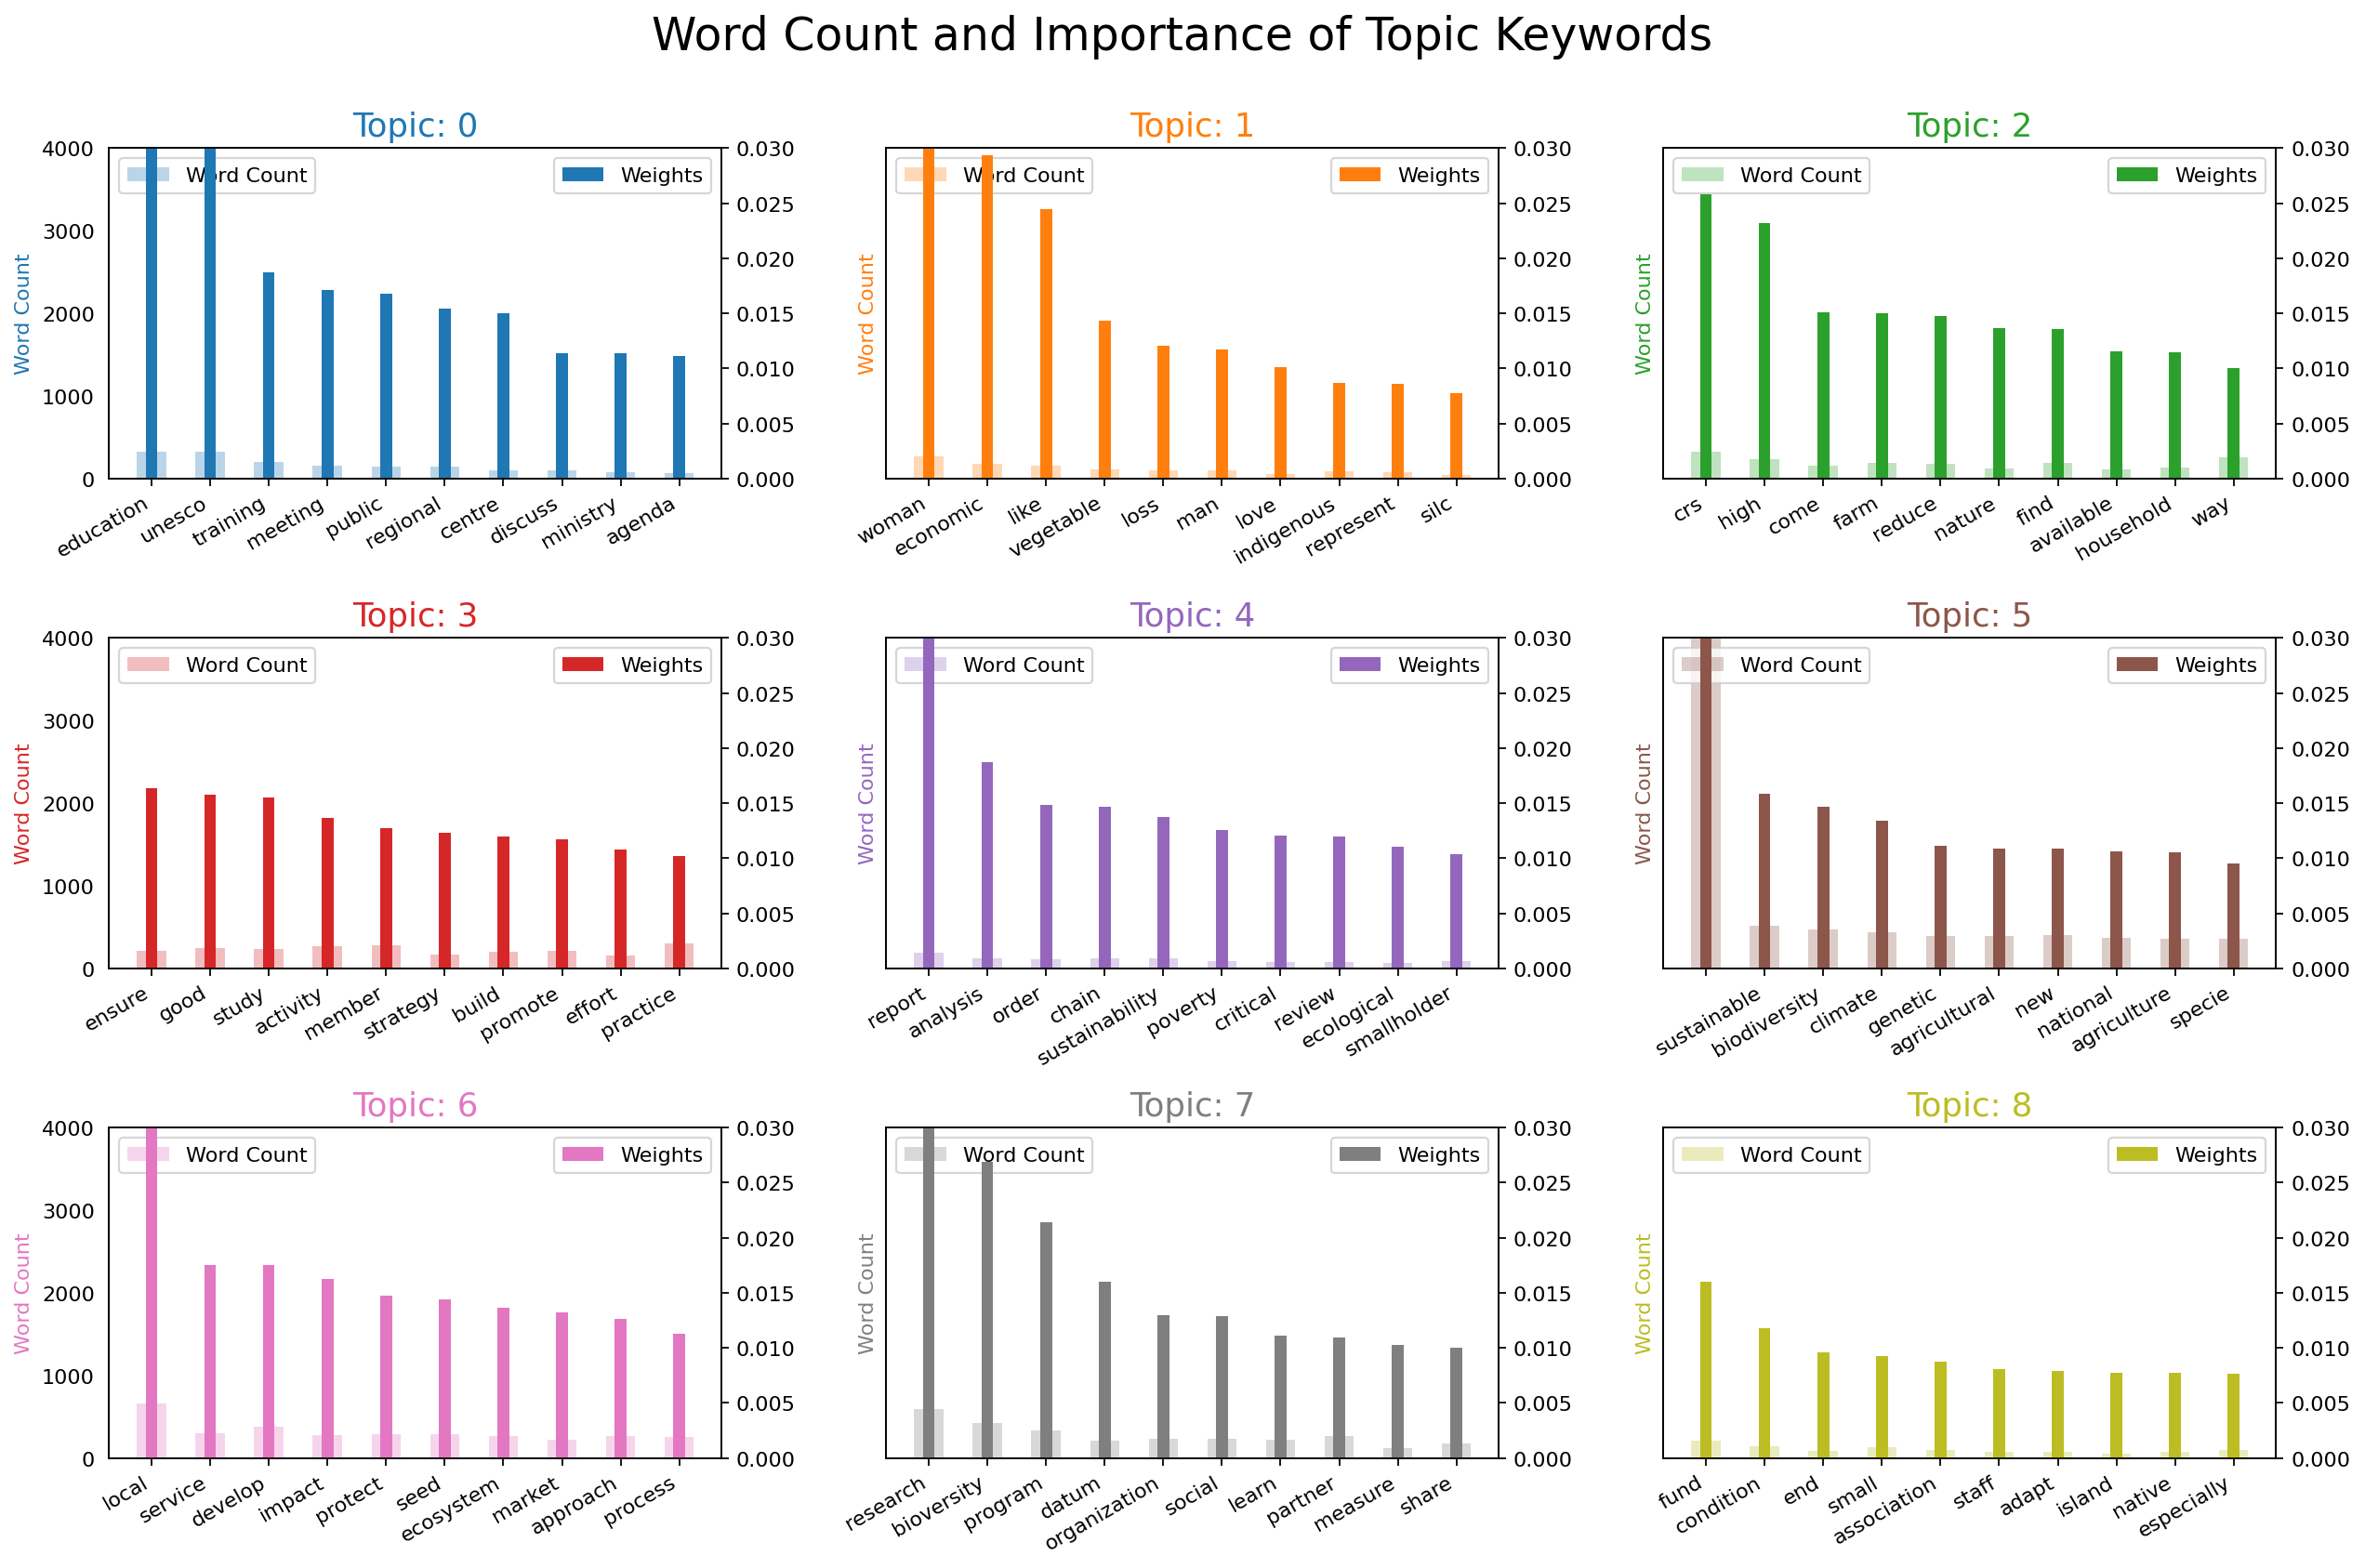

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in doc_list for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 4000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The total number of documents attributed to each topic

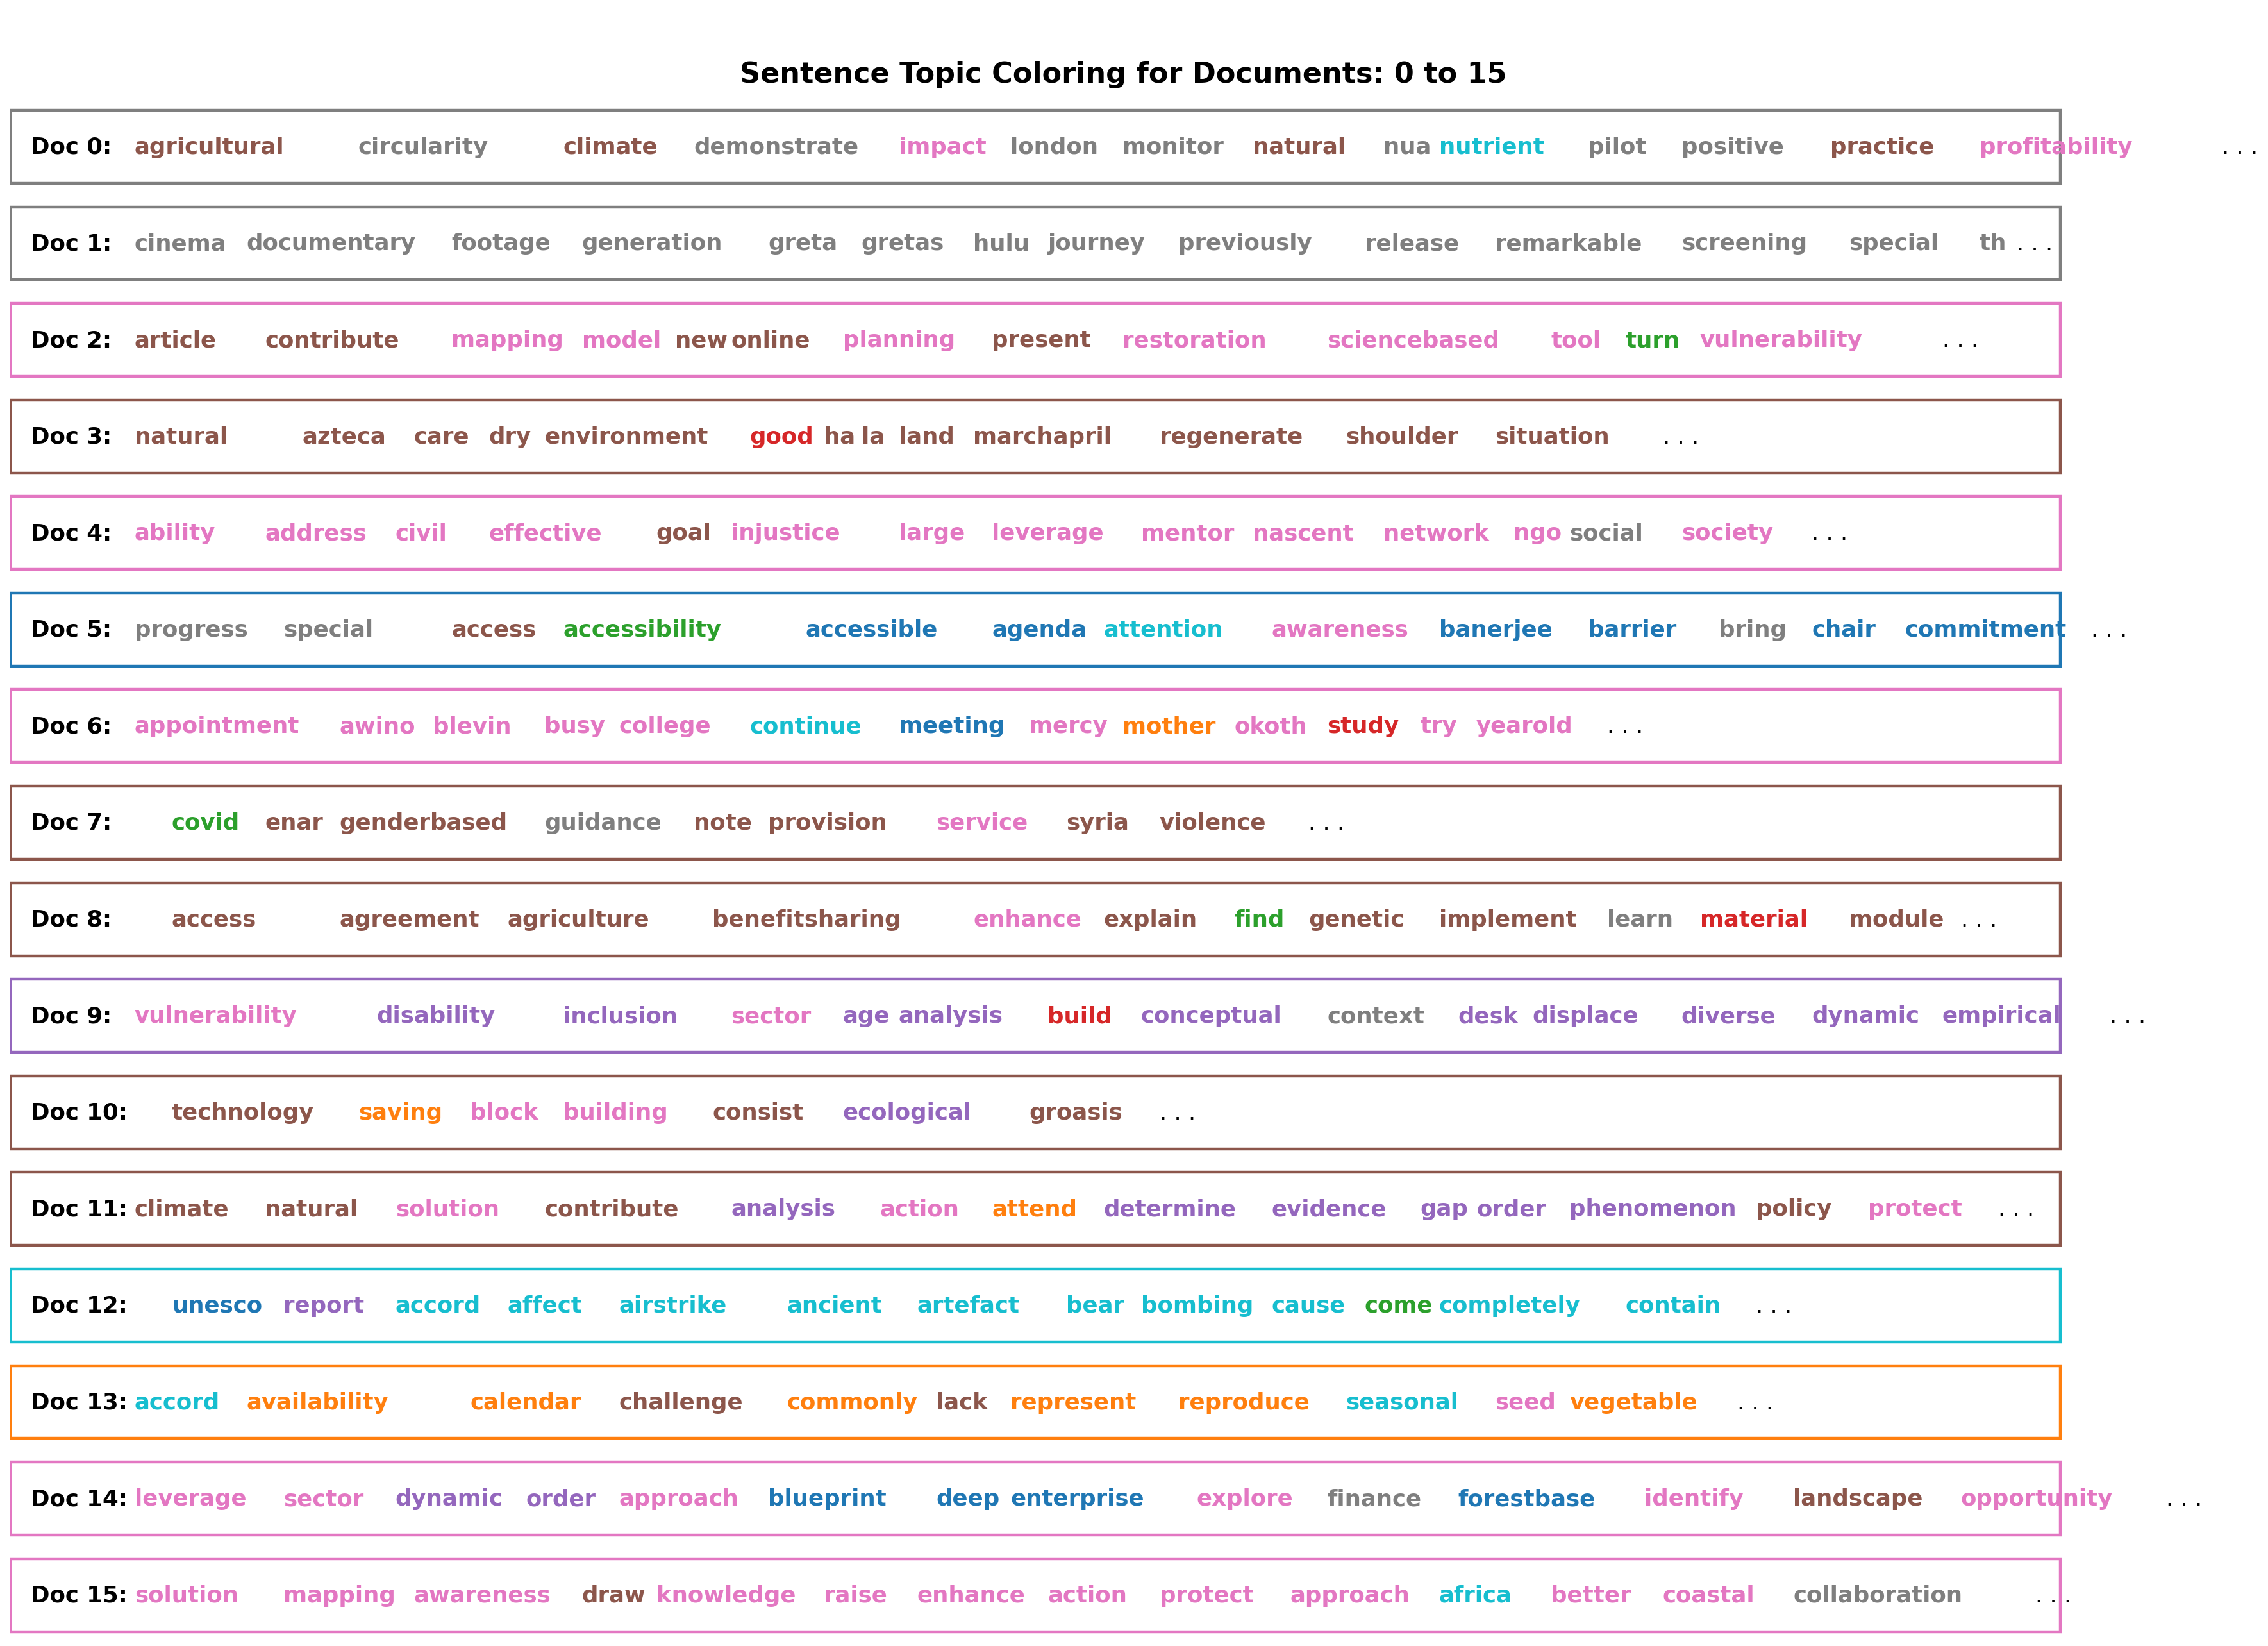

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 17):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(22, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=20, y=0.96, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

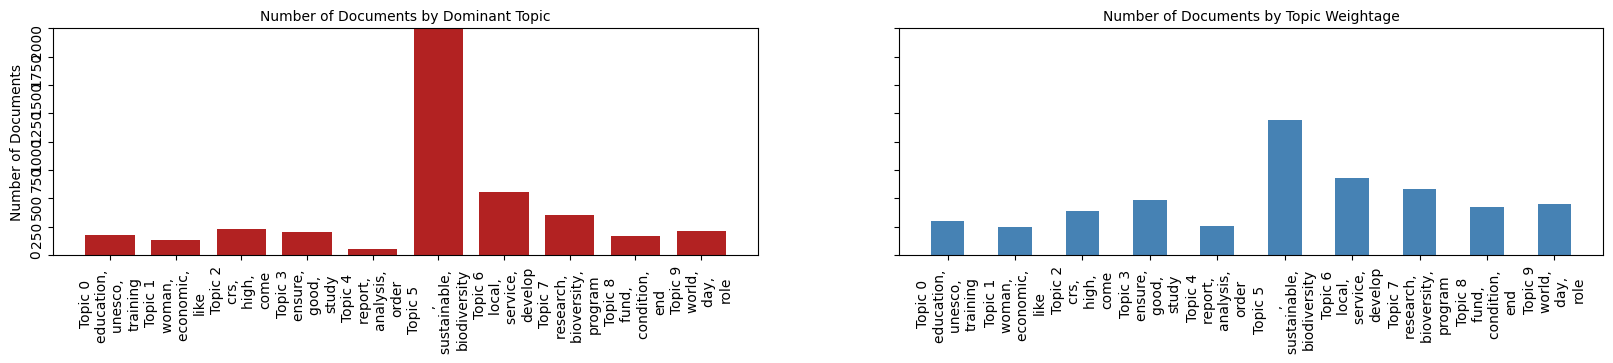

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.75, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2000)
ax1.tick_params(labelrotation=90)
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
ax2.tick_params(labelrotation=90)
plt.show()

TSNE (t-distributed stochastic neighbor embedding) algorithm to visualize the clusters of documents in 2D space

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 571 samples in 0.001s...
[t-SNE] Computed neighbors for 571 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 571 / 571
[t-SNE] Mean sigma: 0.055150
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.747894
[t-SNE] KL divergence after 1000 iterations: 0.597001


In [ ]:
!pip install pyldavis

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.391633 -0.150370       1        1  23.990452
6      0.116649  0.337646       2        1  13.985698
7     -0.023982  0.121913       3        1  11.147759
3     -0.039340  0.023788       4        1   9.926644
9     -0.038298 -0.083897       5        1   8.952973
8     -0.074780 -0.066101       6        1   8.469711
2     -0.085473 -0.050650       7        1   7.536709
0     -0.081973 -0.045311       8        1   5.929309
4     -0.077764 -0.042442       9        1   5.257989
1     -0.086672 -0.044575      10        1   4.802756, topic_info=            Term         Freq        Total Category  logprob  loglift
51                4188.000000  4188.000000  Default  30.0000  30.0000
299        local   604.000000   604.000000  Default  29.0000  29.0000
555     research   529.000000   529.000000  Default  28.0000  28.0000
312    education   331.000000   331.000000  Default  27.0000  27.0000
487   bioversity   398.000000   398.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4120   nonnative    27.018149    27.791161  Topic10  -5.4620   3.0078
1830        rely    26.146829    26.917499  Topic10  -5.4948   3.0069
1415       teach    26.059072    26.829653  Topic10  -5.4981   3.0068
380      survive    25.716955    26.487660  Topic10  -5.5113   3.0065
2303        rate    32.914222    39.302708  Topic10  -5.2646   2.8586

[356 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
51        1  0.999839          
80        1  0.997371    access
211       2  0.997332    action
404       4  0.995360  activity
1782      6  0.996916     adapt
...     ...       ...       ...
576       4  0.990793  workshop
311       1  0.230518     world
311       5  0.770082     world
1307      5  0.993356     yield
577       3  0.996425     young

[352 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 4, 10, 9, 3, 1, 5, 2])